In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd /home/mabitbol/GBT-S140/analysis/

/home/mabitbol/GBT-S140/analysis


In [3]:
import foregrounds as fg
from scipy.optimize import curve_fit
import emcee
import corner

In [4]:
from __future__ import unicode_literals

figsize(10,8)

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
    
rcParams['xtick.labelsize'] = 20
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 1
rcParams['xtick.major.pad'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1

rcParams['ytick.labelsize'] = 20
rcParams['ytick.major.size'] = 10
rcParams['ytick.major.width'] = 1
rcParams['ytick.major.pad'] = 10
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.width'] = 1

rcParams['legend.fontsize'] = 24
rcParams['legend.borderaxespad'] = 1

rcParams['axes.labelsize'] = 24
rcParams['axes.titlesize'] = 24

In [5]:
freqs = np.array([408e6, 4.575e9, 5.625e9, 6.125e9, 28.5e9, 44.1e9, 70.3e9, 143e9, 217e9, 353e9, 545e9, 857e9])

In [6]:
tflux = np.array([18.801622, 14.39028026102544, 15.308315580143558, 17.325469247703559, 31.750941172695569, 29.253926761836542, 29.206905651218467, 94.463011808734421, 441.55181791891386, 1854.9266953135054, 6118.5522287180465, 19702.641285271391])
terrs = 0.2 * tflux

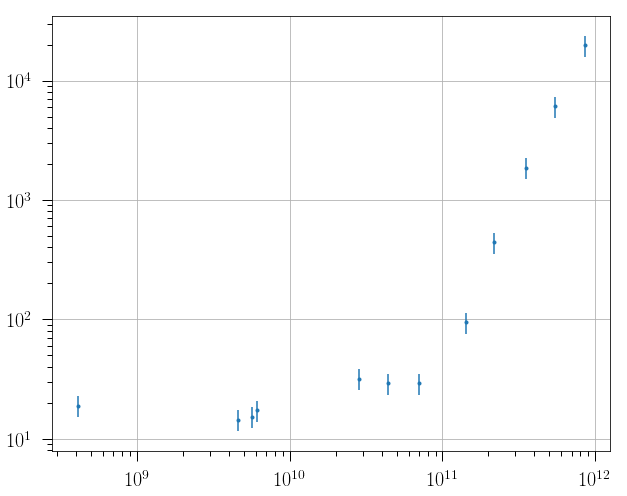

In [7]:
errorbar(freqs, tflux, terrs, fmt='.')
yscale('log')
xscale('log')
grid()

In [8]:
beam = pi*( 2. * pi/180.)**2
beam2 = pi*( (0.16/60.) * pi/180.)**2

In [11]:
def signal(freqs, EM, Asd, nup, Ad, Bd, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=20.)
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) 
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + amefit + ccmb) * beam

In [12]:
def signal2(freqs, EM1, EM2, Ad, Bd, abeam, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=20.) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit + fffit2 + dustfit + ccmb

In [13]:
def signal3(freqs, EM, Ad, Bd, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=20.)
    ccmb = fg.cmb(freqs, A=Acmb)
    return (fffit + dustfit + ccmb) * beam

In [14]:
pn = np.array([1e3, 1e-3, 20e9, 1, 2, 30e-6])
bounds = ( [0, 0, 0, 0, 0, -1], [1e4, 1, 1e11, 1, 3, 1])
x = curve_fit(signal, freqs, tflux, p0=pn, sigma=terrs, absolute_sigma=True, bounds=bounds)
pfit = x[0]

In [15]:
pn2 = np.array([1e3 , 1e7, 0.1, 2, beam2, 30e-6])
bounds2 = ( [0, 1e5, 0, 0, 0, -1.], [1e4, 1e9, 1, 3, 1, 1])
x = curve_fit(signal2, freqs, tflux, p0=pn2, sigma=terrs, absolute_sigma=True, bounds=bounds2)
pfit2 = x[0]

In [16]:
pn3 = np.array([1e3, 1, 2, 30e-6])
bounds3 = ( [0, 0, 0, -1], [1e4, 1, 3, 1])
x = curve_fit(signal3, freqs, tflux, p0=pn3, sigma=terrs, absolute_sigma=True, bounds=bounds3)
pfit3 = x[0]

In [17]:
rchisq1 = np.sum( ( tflux - signal(freqs, *pfit))**2 / terrs**2 ) / (len(freqs) - 6.)
rchisq2 = np.sum( ( tflux - signal2(freqs, *pfit2))**2 / terrs**2 ) / (len(freqs) - 6.)
rchisq3 = np.sum( ( tflux - signal3(freqs, *pfit3))**2 / terrs**2 ) / (len(freqs) - 4.)
print rchisq1, rchisq2, rchisq3

0.394691512232 0.141215287559 1.67454563438


In [18]:
print "EM, Asd, nup, Ad, Bd, Td, Acmb"
pfit

EM, Asd, nup, Ad, Bd, Td, Acmb


array([  4.31568755e+01,   2.13100968e-04,   3.41299592e+10,
         1.79838696e-04,   1.62926930e+00,   1.11866018e-05])

In [19]:
print "EM1, EM2, Ad, Bd, Td, abeam, Acmb"
pfit2

EM1, EM2, Ad, Bd, Td, abeam, Acmb


array([  3.84006143e+01,   9.99500353e+08,   1.84228745e-04,
         1.43969034e+00,   3.62409000e-10,  -2.85877080e-05])

In [20]:
print "EM, Ad, Bd, Td, Acmb"
pfit3

EM, Ad, Bd, Td, Acmb


array([  4.68572123e+01,   1.75141242e-04,   1.79967754e+00,
         2.85944646e-05])

In [23]:
def signal_b(freqs, EM, Asd, nup, Ad, Bd, Acmb):
    fffit = fg.freefreep(freqs, EM=EM, Te=8000.)*beam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=20.)*beam
    amefit = fg.ame(freqs, Asd=Asd, nup=nup) *beam
    ccmb = fg.cmb(freqs, A=Acmb)*beam
    return fffit, dustfit, amefit, ccmb

In [24]:
def signal2_b(freqs, EM1, EM2, Ad, Bd, abeam, Acmb):
    fffit = fg.freefreep(freqs, EM=EM1, Te=8000.) * beam
    fffit2 = fg.freefreep(freqs, EM=EM2, Te=8000.) * abeam
    dustfit = fg.thermal_dust(freqs, Ad=Ad, Bd=Bd, Td=20.) * beam
    ccmb = fg.cmb(freqs, A=Acmb) * beam
    return fffit, dustfit, fffit2, ccmb

In [25]:
nu = np.linspace(freqs[0], freqs[-1], 1000)

In [26]:
fffit, dustfit, amefit, ccmb = signal_b(nu, *pfit)

In [27]:
fffit2, dustfit2, fffit3, ccmb2 = signal2_b(nu, *pfit2)

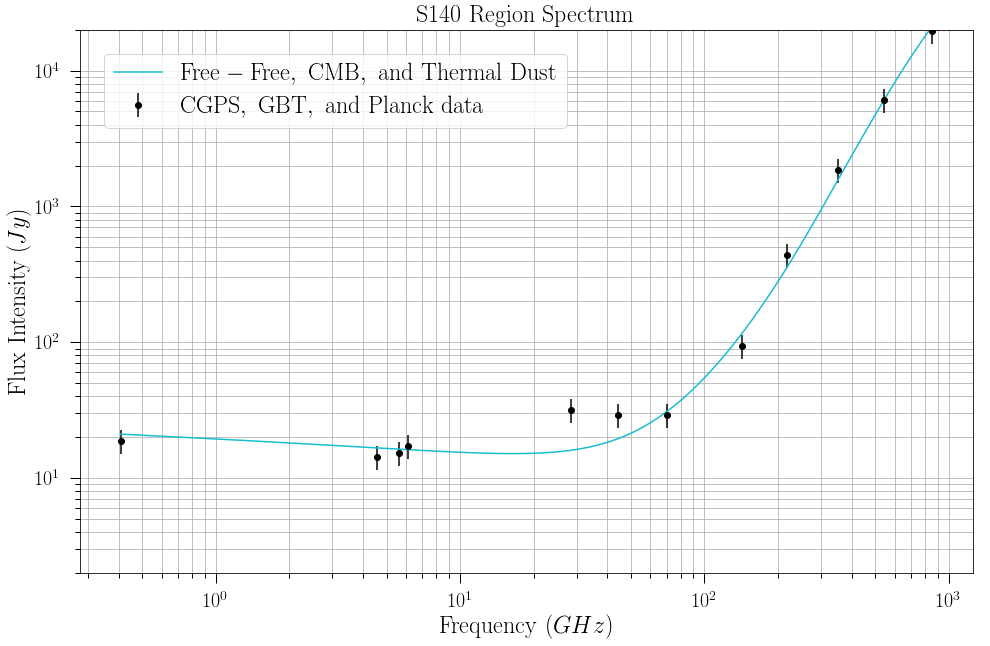

In [28]:
figure(figsize=(16,10))
plot(nu*1e-9, signal3(nu, *pfit3), label='$\mathrm{Free-Free,\ CMB,\ and\ Thermal\ Dust}$', c='C9')
errorbar(freqs*1e-9, tflux, yerr=terrs, fmt='ko',label='$\mathrm{CGPS,\ GBT,\ and\ Planck\ data}$')

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency}\ (GHz)$')
ylabel('$\mathrm{Flux\ Intensity}\ (Jy)$')
legend(loc=2, ncol=1)
grid()
ylim(2, 2e4)
grid(which='minor')
title('$\mathrm{S140\ Region\ Spectrum}$')
#savefig('../notebooks/wholeregion_smoothed_spectrum_excess')

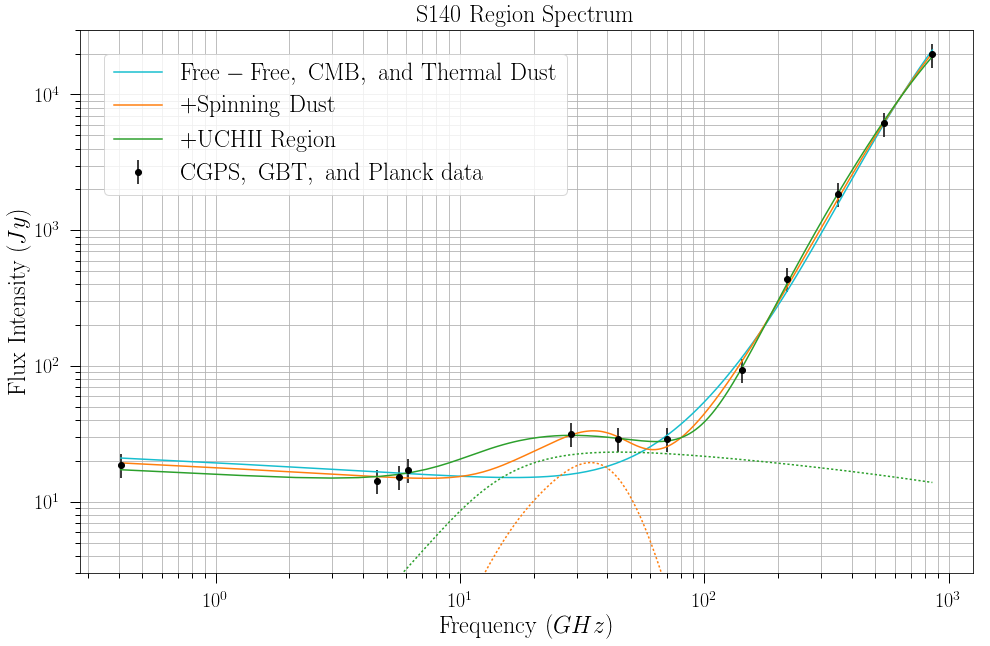

In [31]:
figure(figsize=(16,10))
plot(nu*1e-9, signal3(nu, *pfit3), label='$\mathrm{Free-Free,\ CMB,\ and\ Thermal\ Dust}$', c='C9')
plot(nu*1e-9, signal(nu, *pfit), label='$\mathrm{+Spinning\ Dust}$', c='C1')
plot(nu*1e-9, signal2(nu, *pfit2), label='$\mathrm{+UCHII\ Region}$', c='C2')
errorbar(freqs*1e-9, tflux, yerr=terrs, fmt='ko',label='$\mathrm{CGPS,\ GBT,\ and\ Planck\ data}$')
plot(nu*1e-9, amefit, ls='dotted', c='C1')
plot(nu*1e-9, fffit3, ls='dotted', c='C2')

xscale('log')
yscale('log')
xlabel('$\mathrm{Frequency}\ (GHz)$')
ylabel('$\mathrm{Flux\ Intensity}\ (Jy)$')
legend(loc=2, ncol=1)
grid()
ylim(3, 3e4)
grid(which='minor')
title('$\mathrm{S140\ Region\ Spectrum}$')
savefig('../notebooks/wholeregion_smoothed_spectrum_ame')